# Исследование мобильной игры Quiz Freeze

## Задачи:
### 1. Определить, насколько обучение сокращает время прохождения этапов игры.
### 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
### 3. Определить, насколько прозрачен процесс взаимодействия с игрой.

In [214]:
#Читаем данные, преобразуем время в формат datetime
import pandas as pd
events = pd.read_csv('data/events.csv')
purchases = pd.read_csv('data/purchase.csv')
events['start_time'] = pd.to_datetime(events['start_time'], errors='coerce')
purchases['event_datetime'] = pd.to_datetime(
    purchases['event_datetime'], errors='coerce'
)

In [215]:
#Формируем датафрейм с пользователями, зарегистрировавшимися в 2018-м году
mask1 = events['event_type'] == 'registration'
mask2 = events['start_time'].dt.year == 2018
df_reg_2018 = events[mask1 & mask2]
users_2018_lst = df_reg_2018['user_id'].to_list()
events_df = events[events['user_id'].isin(users_2018_lst)].reset_index(drop=True)
purchases_df = purchases[
    purchases['user_id'].isin(users_2018_lst)
].reset_index(drop=True)


In [216]:
#Скорректируем столбцы обеих датафреймов для объединения
events_df = events_df.rename(columns={'id': 'event_id'})

purchases_df['event_type'] = 'purchase'
purchases_df = purchases_df.rename(
    columns={'id': 'purchase_id', 'event_datetime': 'start_time'}
)

In [217]:
#Объединяем датафреймы
total_df = pd.concat([events_df, purchases_df])

### 1. Определить, насколько обучение сокращает время прохождения этапов игры.

Создаём сводную таблицу с указанием времени начала каждого этапа для каждого пользователя:

In [218]:
user_time_df = total_df.pivot_table(
    values='start_time',
    index='user_id',
    columns='event_type',
    aggfunc='min'
)


Вычисляем время прохождения каждого этапа для каждого пользователя:

In [219]:

user_time_df['reg - level_choice'] = user_time_df['level_choice'] \
    - user_time_df['registration']
user_time_df['level_choice - pack_choice'] = user_time_df['pack_choice'] \
    - user_time_df['level_choice']
user_time_df['pack_choice - purchase'] = user_time_df['purchase'] \
    - user_time_df['pack_choice']

In [220]:
#Сбрасываем и переименовываем индекс
user_time_df = user_time_df.reset_index()
user_time_df.index.rename('index', inplace=True)

Определим группы пользователей, прошедших обучение и отказавшихся от обучения:

In [221]:
users_with_finished_tutorial = set(
    total_df[total_df['event_type'] == 'tutorial_finish']['user_id'].unique()
)

users_with_started_tutorial = set(
    total_df[total_df['event_type'] == 'tutorial_start']['user_id'].unique()
)
all_users = set(total_df['user_id'].unique())

users_wo_tutorial = all_users.difference(users_with_started_tutorial)

Создадим отдельный признак, отвечающий за наличие пройденного обучения либо его полное отсутствие:

In [222]:
def set_status(user):
    if user in users_with_finished_tutorial:
        return 'finished tutorial'
    elif user in users_wo_tutorial:
        return 'not started tutorial'

user_time_df['status'] = user_time_df.user_id.apply(set_status)
user_time_df.head()

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,reg - level_choice,level_choice - pack_choice,pack_choice - purchase,status
index,,,,,,,,,,,
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,not started tutorial
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT,NaT,NaT,finished tutorial
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT,NaT,NaT,finished tutorial
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 08:42:35,0 days 00:01:21,NaT,finished tutorial
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT,NaT,NaT,finished tutorial


Создадим таблицу с данными, отражающими среднее время прохождения различных этапов пользователями\
в группах пользователей, прошедших обучение и не начинавших его:

In [223]:
groups = user_time_df.groupby('status')[
    ['reg - level_choice', 'level_choice - pack_choice', 'pack_choice - purchase']
].mean()
display(groups)

event_type,reg - level_choice,level_choice - pack_choice,pack_choice - purchase
status,,,
finished tutorial,0 days 07:05:36.854819357,0 days 00:05:18.146058732,3 days 17:17:59.641326883
not started tutorial,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090


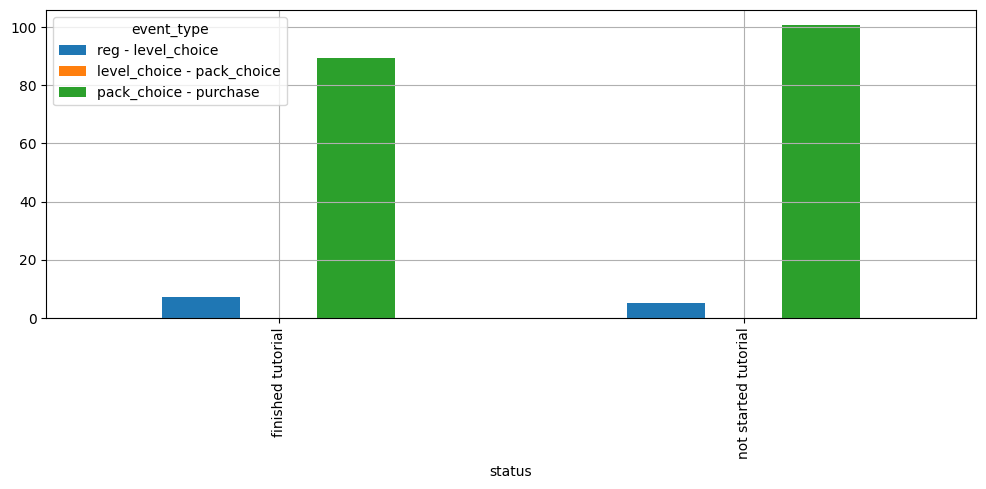

In [224]:
groups_diagram = groups/pd.Timedelta('1 hour')
groups_diagram.plot(
    kind='bar',
    grid=True,
    figsize=(12,4)    
);

### Выводы:
Из данных мы видим, что время **от регистрации до выбора уровня сложности** занимает больше времени у пользователей, прошедших обучение (в среднем на 2 часа),
что, скорее всего, объясняется тем, что именно на этом этапе пользователи проходят обучение, засчёт которого время прохождения этого этапа у обучившихся пользователей дольше.

Этап от выбора уровня сложности до выбора пакета вопросов у обоих групп примерно одинаков, всего около 5 минут, и как таковой не занимает много времени.

Самым показательным является третий этап, **от выбора пакета вопросов до выбора пакета платных вопросов** (и, соответственно, оплаты). Здесь мы явно видим, что прошедшие обучение пользователи гораздо решительнее в выборе платных вопросов, что показывают и зелёные столбцы диаграммы (разница составляет 7-8 часов). 

### 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.


Посчитаем количество событий для каждого пользователя

In [225]:
events_cnt_df = total_df.pivot_table(
    values='start_time',
    index='user_id',
    columns='event_type',
    aggfunc='count',
    fill_value=0
).reset_index()

Посчитаем количество покупок платного пакета вопросов в зависимости от количества попыток начала обучения, \
а также количество зарегистрировавшихся пользователей в каждой группе

In [226]:
tutorial_purchase_df = events_cnt_df.groupby(
    'tutorial_start'
)['registration','purchase'].sum().reset_index()
tutorial_purchase_df.index.rename('index', inplace=True)

C:\Users\79313\AppData\Local\Temp\ipykernel_6168\1464828355.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tutorial_purchase_df = events_cnt_df.groupby(


Выведем признак, отвечающих за конверсию зарегистрировавшихся пользователей в покупателей платного пакета вопросов:

In [227]:
tutorial_purchase_df['CR'] = round(
    tutorial_purchase_df['purchase']/tutorial_purchase_df['registration'] * 100, 2
)
tutorial_purchase_df

event_type,tutorial_start,registration,purchase,CR
index,,,,
0,0,8068,22,0.27
1,1,9103,1207,13.26
2,2,1589,218,13.72
3,3,427,51,11.94
4,4,221,30,13.57
5,5,109,16,14.68
6,6,116,14,12.07
7,7,94,12,12.77
8,8,86,13,15.12


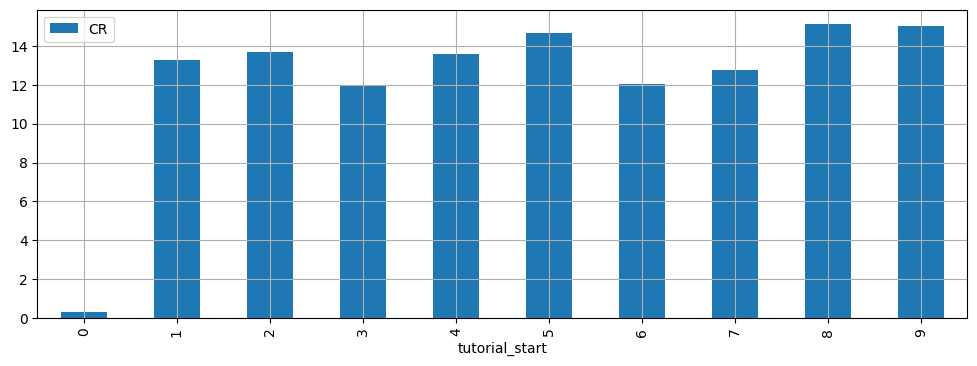

In [228]:
tutorial_purchase_df.plot(
    kind='bar',
    grid=True,
    figsize=(12,4),
    x='tutorial_start',
    y='CR'
);

### Выводы:

Мы можем констатировать, что конверсия у всех групп пользователей, **начавших хотя бы раз обучение**, варьируется незначительно **в пределах 12-15 %**.

В то же время очевидно, что конверсия этой группы пользователей значительно выше по сравнению с группой ни разу не начавших обучение.\
Конверсия пользователей, **не прошедших обучение**, составляет **менее 0,5 %**.

### 3. Определить, насколько прозрачен процесс взаимодействия с игрой.

Определим количество всех пользователей, выбравших уровень сложности

In [229]:
level_choice_users = total_df[
    total_df['event_type'] == 'level_choice'
]['user_id'].nunique()
print(f'Количество всех пользователей, '
      f'выбравших уровень сложности: {level_choice_users}')

Количество всех пользователей, выбравших уровень сложности: 8342


Создадим таблицу с самым поздним временем начала обучения для каждого пользователя:

In [230]:
tutorial_start_df = total_df[
    total_df['event_type'] == 'tutorial_start'
].rename(columns={'start_time':'tutorial_start'})

tutorial_start_df = tutorial_start_df.groupby(
    'user_id'
)['tutorial_start'].max().reset_index()
tutorial_start_df.head()

,user_id,tutorial_start
0,27833,2018-01-01 17:47:40
1,27834,2018-01-01 19:46:11
2,27835,2018-01-01 15:00:51
3,27836,2018-01-01 15:40:43
4,27839,2018-01-01 19:11:36


Создадим таблицу с самым ранним временем выбора уровня сложности для каждого пользователя:

In [231]:
level_choice_df = total_df[
    total_df['event_type'] == 'level_choice'
].rename(columns={'start_time':'level_choice_start'})

level_choice_df = level_choice_df.groupby(
    'user_id'
)['level_choice_start'].min().reset_index()
level_choice_df.head()

,user_id,level_choice_start
0,27835,2018-01-01 20:37:22
1,27839,2018-01-01 22:37:50
2,27840,2018-01-02 05:18:42
3,27842,2018-01-02 08:46:03
4,27843,2018-01-02 14:09:58


Объединяем обе получившиеся таблицы и создаём столбец, \
отражающий разницу во времени между самым поздним временем начала обучения \
и самым ранним временем выбора уровня сложности:

In [232]:
level_tutorial_df = tutorial_start_df.merge(level_choice_df, on='user_id', how='inner')
level_tutorial_df['time_diff'] = (level_tutorial_df['level_choice_start'] 
    - level_tutorial_df['tutorial_start'])

In [233]:
level_tutorial_df['time_diff'] = (level_tutorial_df['time_diff']
    /pd.Timedelta('1 second'))
level_tutorial_df.head()

,user_id,tutorial_start,level_choice_start,time_diff
0,27835,2018-01-01 15:00:51,2018-01-01 20:37:22,20191.0
1,27839,2018-01-01 19:11:36,2018-01-01 22:37:50,12374.0
2,27840,2018-01-02 02:07:07,2018-01-02 05:18:42,11495.0
3,27842,2018-01-02 18:08:01,2018-01-02 08:46:03,-33718.0
4,27843,2018-01-02 13:34:51,2018-01-02 14:09:58,2107.0


Если значение столбца time_diff отрицательное, значит, \
пользователь хотя бы раз вернулся к обучению после выбора уровня сложности.  
Теперь мы можем подсчитать общее количество таких пользователей:

In [234]:
tutorial_after_level_ch_users = level_tutorial_df[
    level_tutorial_df['time_diff'] < 0
]['user_id'].count()

print(f'Количество пользователей, '
      f'вернувшихся к обучению после этапа выбора уровня сложности: '
      f'{tutorial_after_level_ch_users}')

Количество пользователей, вернувшихся к обучению после этапа выбора уровня сложности: 1386


Вычислим процент пользователей, вернувшихся к обучению, относительно всех выбравших уровень сложности пользователей:

In [236]:
print(f'Количество всех пользователей, '
      f'выбравших уровень сложности: {level_choice_users}')
print(
    f'Количество пользователей, '
    f'вернувшихся к обучению после этапа выбора уровня сложности: '
    f'{tutorial_after_level_ch_users}'
)

tutorial_after_level_ch_percent = round(
    tutorial_after_level_ch_users/level_choice_users * 100, 2
)
print(
    f'Процент пользователей, вернувшихся к обучению '
    f'после выбора уровня сложности: {tutorial_after_level_ch_percent} %'
)

Количество всех пользователей, выбравших уровень сложности: 8342
Количество пользователей, вернувшихся к обучению после этапа выбора уровня сложности: 1386
Процент пользователей, вернувшихся к обучению после выбора уровня сложности: 16.61 %


### Вывод:
Как мы видим, **17 % пользователей** возвращаются к обучению после начала игры,\
что является довольно неплохим показателем.

## Общие выводы:

1. Пользователи, **прошедшие обучение**, значительно быстрее переходят от выбора уровня сложности **к покупке платных пакетов вопросов** по сравнению с не прошедшими обучение (в среднем на 7-8 часов)
2. **Конверсия** пользователей, хотя бы раз начавших **обучение**, не зависит от количества обучений, составляет **12 - 15 %** и значительно выше, чем у пользователей, не начавших обучение ни разу.
3. Процесс обучения в игре прозрачен в достаточной степени, после начала игры только около **17 % пользователей возвращаются к обучению**. 
4. Обучение как этап в игре оказывается значимым фактором для привлечения пользователей к платным услугам, имеет смысл подумать, как дополнительно привлечь внимание пользователей к этому этапу или даже, возможно, сделать обучение в игре обязательным для всех пользователей - с целью повысить конверсию. 